Notebook for analyzing the outputs of the LAMMPS simulations for the branched polymers.

Works with .lammpstrj and .log files.

By: Mihir Gowda



### Dependencies

In [ ]:
!pip install -q MDAnalysis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 4.1 MB/s eta 0:00:00


In [ ]:
import MDAnalysis as mda
from MDAnalysis.analysis.rms import RMSD

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import matplotlib as mpl
import os

#### Functions

In [ ]:
def extractradiusofg(filename):
  """
  Take a .log file and return timestep, radius of gyration

  output
  ----------
  radiusofg: radius of gyration


  Relies on identification of two specific lines
  """

#   timesteps = []
  radius = []

  start = False
  with open(filename, "r+") as f:
    for index, line in enumerate(f):
      if 'Loop time' in line:
        start = False
      if 'WARNING' in line:
        start = False
      if 'Fix' in line:
        continue
      if start:
        linelist = ([i for i in line.split(' ') if i != ''][:4])
        if len(linelist) < 4:
            start = False
            break
        # timesteps.append(int(linelist[0]))
        radius.append(float(linelist[3]))
      if 'Step' in line and 'Temp' in line and 'Enthalpy' in line and 'c_1' in line:
        start = True

  #return np.array(timeandrad)
  return np.array(radius)




In [ ]:
def get_file_list(folderpath):
    return [folderpath + '/' + f for f in os.listdir(folderpath) if os.path.isfile(folderpath + '/' + f)]


In [ ]:
def get_file_list_V2(folderpath):
    l = get_file_list(folderpath)
    return sorted(l, key =  lambda x: int(x.replace("bb", "*").replace("nuc", "*").split("*")[1]))

### Running the Simulations

The following are 3 different command line inputs to run the LAMMPS MD simulation from the .lam files

In [ ]:
# ONLY IF openMPI has been installed for parallel thread processing
# Use mpiexec over mpirun due to it being a standardized protocol
!env OMP_NUM_THREADS=2 mpiexec -np 2 lmp -sf omp -in branchedpolymer.lam

In [ ]:
# OTHERWISE if openMP is possible with the LAMMPS build
# OpenMP threading:
!env OMP_NUM_THREADS=2 lmp -sf omp -in branchedpolymer.lam

In [ ]:
# OTHERWISE if neither openMP or openMPI are accessible
!lmp -in branchedpolymer{shape}.lam

### User-defined variables for Analysis

In [ ]:
# Folder names / Branched polymer categories
labels = ["Linear", "N1B3", "N1B4", "N1B5", "N3B4", "N5B4", "N7B4"]


trials = ["", "trial2/", "trial3/"]
runs = ["", "2", "3"]
rog_labels = labels
folders = labels
colormap = ["blue", "orange", "green", "red", "purple", "pink", "brown"]
mpl.style.use('seaborn-talk')

mononuc_i = [0, 1, 2, 3]
multinuc_i = [0, 4, 5, 6]

axes_fsize = 20
tick_fsize = 16

# google
# mount google drive!
folderpath = "drive/MyDrive/HarvLab/Thesis/ThesisWork/BranchedPolymers/"

<ipython-input-7-9f214c7ff5f4>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-talk')


### ROG

In [ ]:
# General setup, extracting ROG data from log files
# Takes ~2m with 3 forms

def file_rog(path):
    """
    Captures radius of g from every .log file under the directory specified <path>
    """
    return [extractradiusofg(f) for f in sorted(get_file_list(path), key = lambda x: int(x.replace("bb", "*").replace("nuc", "*").split("*")[1]))]


rog_master = []


for tn, t in enumerate(trials):
    rog_master.append([])
    for nn, n in enumerate(runs):
        rog_master[tn].append([])
        for formn, form in enumerate(labels):
            rog_master[tn][nn].append([])
            rog_master[tn][nn][formn] = file_rog(folderpath + form + "/" + t + "logs" + n)

# run_master in format:
# run_master[trial (3)][run (3)][form (7)][atomtotal (12)]

In [ ]:
# Timestep data for polymers to achieve ROG < 7 from intial
# Adapted for multiple trials in rog_master


def cutoffformula(arr):
    """
    With a list input with multiple arrays of rogs <arr>, return the cutoff lengths.
    """
    return np.array([len(i[i>7]) for i in arr])


# cutoff_master = []
cutoff_master = np.zeros((len(trials), len(runs), len(labels), 12))

for tn in range(len(trials)):
    # cutoff_master.append([])
    for nn in range(len(runs)):
        # cutoff_master.append([])
        for formn in range(len(labels)):
            # cutoff_master.append([])
            cutoff_master[tn][nn][formn] = cutoffformula(rog_master[tn][nn][formn])

cutoffmeans = np.mean(cutoff_master, (0, 1))
cutoffstds = np.std(cutoff_master, (0, 1)) / np.sqrt(9)

# cutoffmeans format:
# cutoffmeans[form (7)][atomtotal (12)]

#### (ROG) Visualizing Compaction

##### older

In [ ]:
def rog_plot(title, rogs):
    """
    Given a title and the radii of gyration for a polymer type,
    plot the radii of gyration until a cutoff of 7 over time.

    args
    ------------
    title: string
    rogs: list of arrays
    """
    for i, rog in enumerate(rogs):
        mpl.style.use('seaborn-talk')
        plt.plot(rog[rog > 7], label=f"n = {(i+1) * 100}", c = (.08*i, 0, 1-.08*i))
        plt.ylabel(r"Radius of Gyration ($\omega$)")
        plt.xlabel("Timestep")
        plt.title(title)
    plt.axvline(100, linestyle='dashed', c='black', label="Relaxation End", alpha = .5)
    plt.legend()

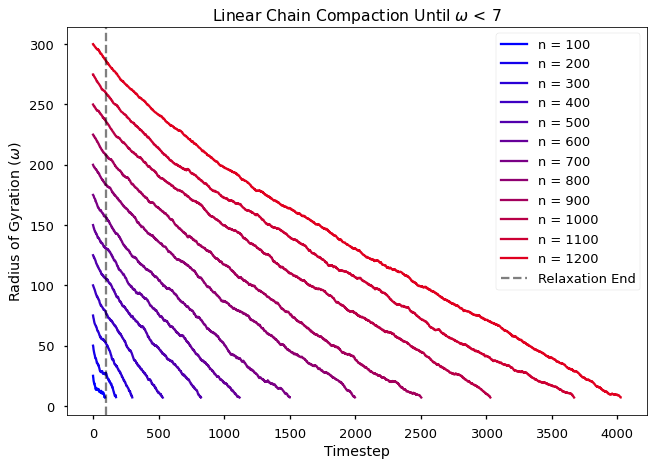

In [ ]:
rog_plot(r"Linear Chain Compaction Until $\omega$ < 7", l_rogs)

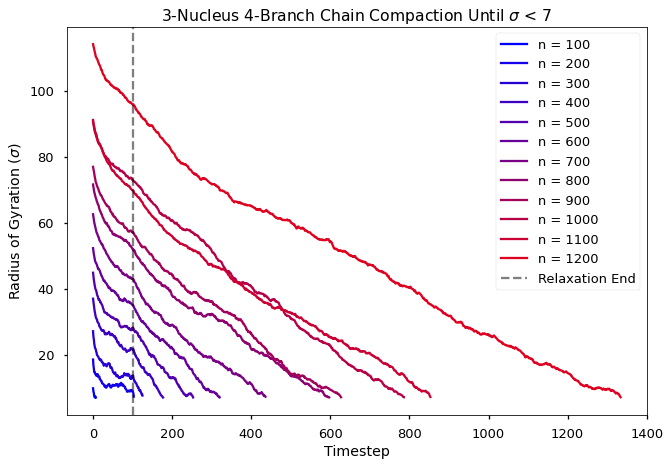

In [ ]:
rog_plot(r"3-Nucleus 4-Branch Chain Compaction Until $\sigma$ < 7", n3b4_rogs)

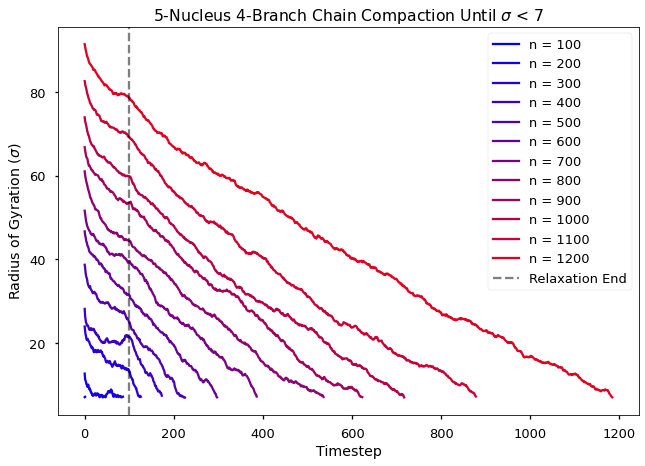

In [ ]:
rog_plot(r"5-Nucleus 4-Branch Chain Compaction Until $\sigma$ < 7", n5b4_rogs)

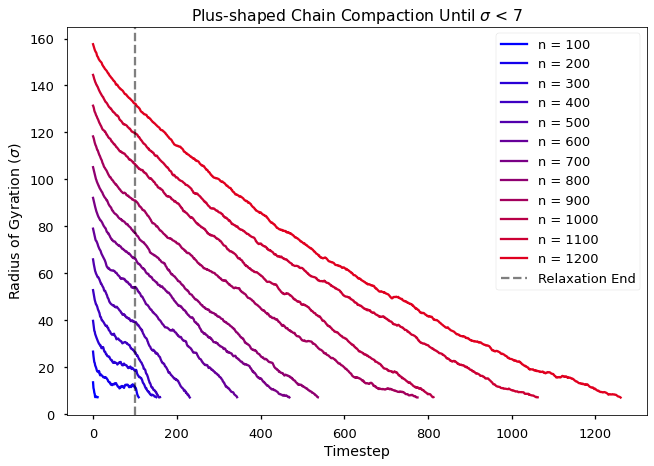

In [ ]:
rog_plot(r"Plus-shaped Chain Compaction Until $\sigma$ < 7", p_rogs)

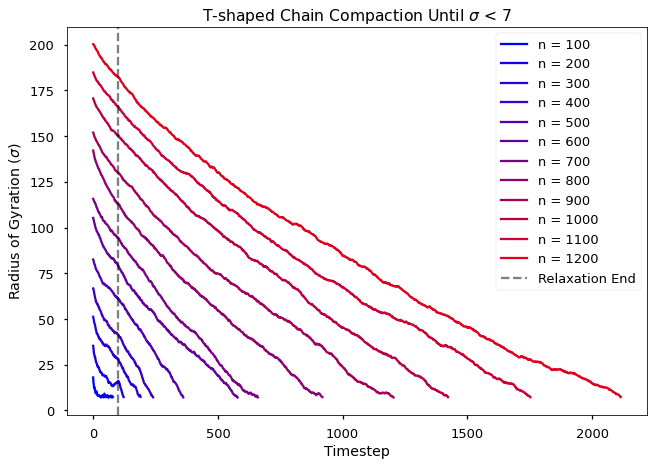

In [ ]:
rog_plot(r"T-shaped Chain Compaction Until $\sigma$ < 7", t_rogs)

In [ ]:
def rog_plot_one_n(n):
    """
    Given the total number of monomers (n) desired, plot the ROG over time
    of each polymer that equals n.

    args
    ------
    n: total number of polymers
    """
    fig, axs = plt.subplots(1, 1)
    # axs = axs.unravel()

    mpl.style.use('seaborn-talk')

    for formn in range(len(labels)):
        for tn in range(len(trials)):
            for nn in range(len(runs)):
                rog_i = rog_master[tn][nn][formn][int((n/100) - 1)]
                # highlight first run case
                if tn == 1 and nn == 0:
                    axs.plot(rog_i[rog_i > 7], c=colormap[formn], label=labels[formn])

                # other run cases are much more transparent
                else:
                    axs.plot(rog_i[rog_i > 7], alpha=.2, c=colormap[formn])

    axs.axvline(100, linestyle='dashed', c='black', label="Relaxation End", alpha = .5)
    axs.tick_params(labelsize=tick_fsize)
    axs.legend(title=f"n = {n}", fontsize=tick_fsize, title_fontsize=axes_fsize)
    fig.supylabel(r"Radius of Gyration ($\omega$)", fontsize=axes_fsize)
    fig.supxlabel("Timestep", fontsize=axes_fsize)



<ipython-input-36-4e25dd476602>:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-talk')


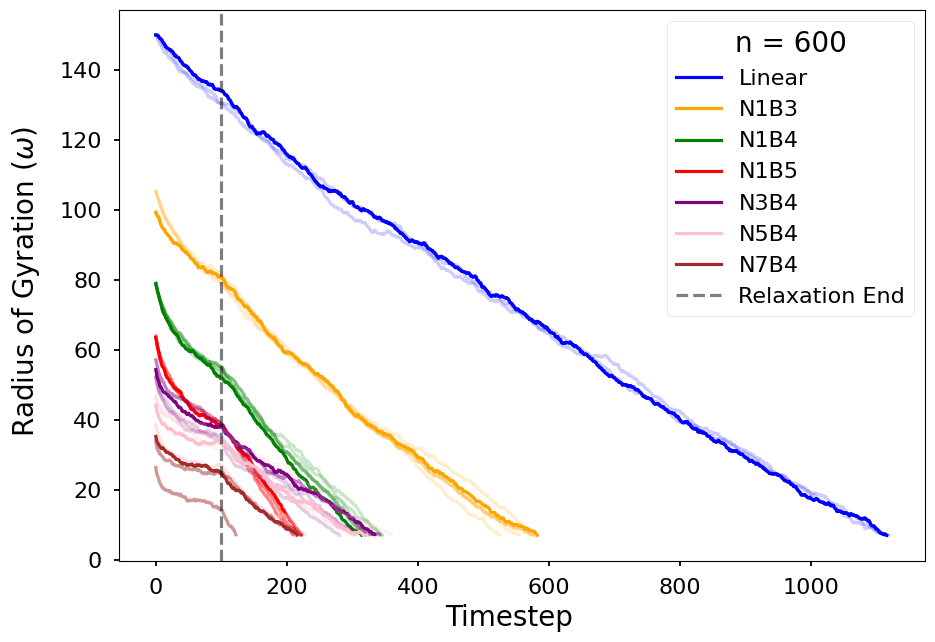

In [ ]:
# Example: For each polymer that has n = 600 total monomers,
# plot ROG over time until < 7.
rog_plot_one_n(600)

<ipython-input-36-4e25dd476602>:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-talk')


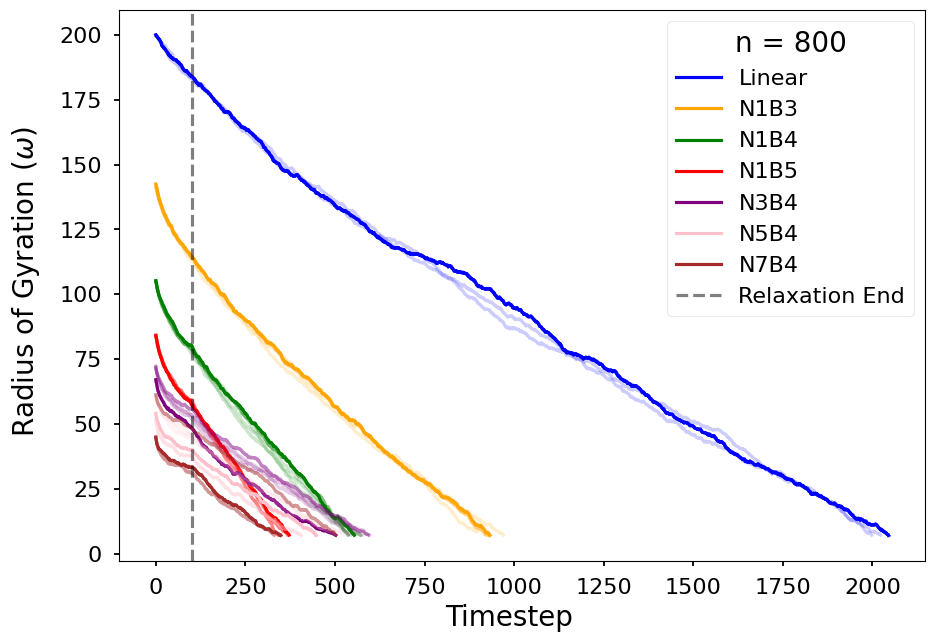

In [ ]:
rog_plot_one_n(800)

<ipython-input-36-4e25dd476602>:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-talk')


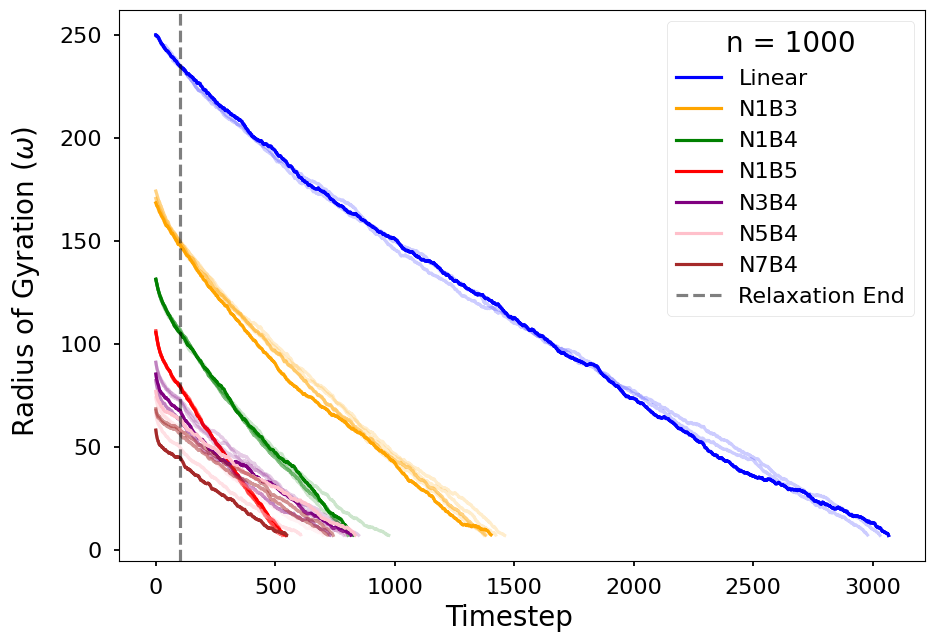

In [ ]:
rog_plot_one_n(1000)

In [ ]:
def rog_plot_one_startingrog(r):

    """
    Given a radius of gyration value of n, find from each polymer the closest
    molecule that starts with that radius of gyration, and plot change over time.
    Stops when ROG < 7.

    args
    ------
    n: radius of gyration to match a polymer from each type with
    """

    def find_nearest(array, value):
        array = np.asarray(array)
        val = array[(np.abs(array - value)).argmin()]
        return np.where(array == val)[0][0]

    # colormap = ["blue", "orange", "green", "red", "purple"]

    for i, rog in enumerate(rog_list):
        starting_poss = [v[0] for v in rog[2:]]
        index = find_nearest(starting_poss, r) + 2
        n = (index+1)*100
        mpl.style.use('seaborn-talk')
        rog_of_choice = rog[index]
        r2 = rog_list2[i][index]
        r3 = rog_list3[i][index]
        plt.plot(rog_of_choice[rog_of_choice > 7], c=colormap[i], label=rog_labels[i] + f', n = {n}, $\epsilon$ = {np.round(np.abs(r - rog_of_choice[0]), 1)}')
        plt.plot(r2, alpha = .2, c=colormap[i])
        plt.plot(r3, alpha = .2, c=colormap[i])
        plt.ylabel(r"Radius of Gyration ($\omega$)")
        plt.xlabel("Timestep")
        plt.title(f"Chain Compaction for Starting $\omega$ = {r} Until $\omega$ < 7")
        plt.grid(alpha = .7)
    plt.axvline(100, linestyle='dashed', c='black', label="Relaxation End", alpha = .5)
    plt.legend(fontsize=18)


<ipython-input-10-cf4e3a1bc6ea>:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-talk')
<ipython-input-10-cf4e3a1bc6ea>:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-talk')
<ipython-input-10-cf4e3a1bc6ea>:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


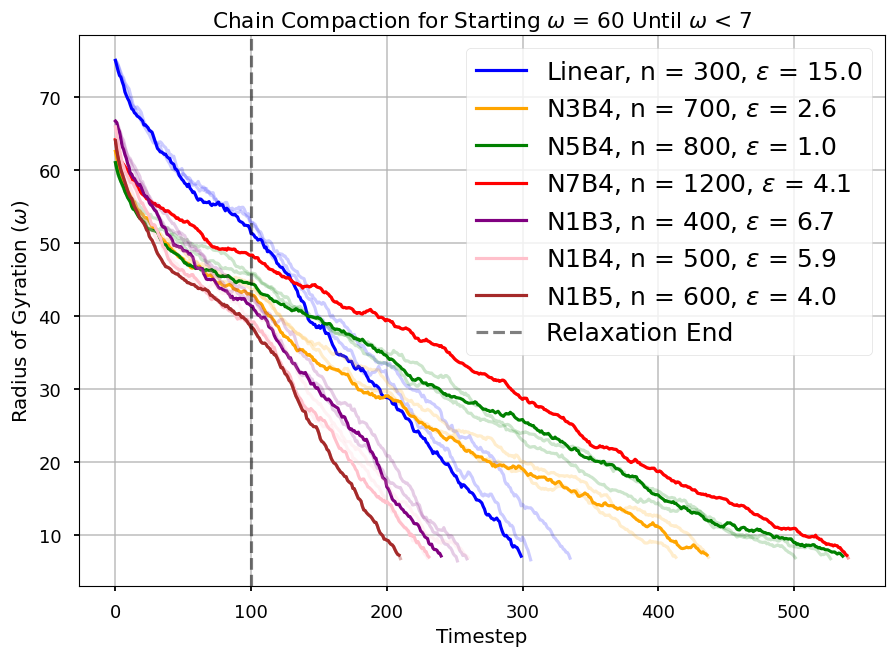

In [ ]:
# Example: find closest polymers from each type that start at
# a ROG of 6
rog_plot_one_startingrog(60)

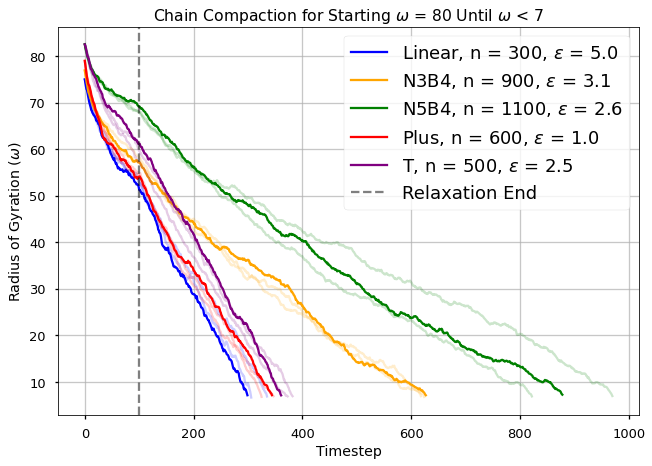

In [ ]:
rog_plot_one_startingrog(80)

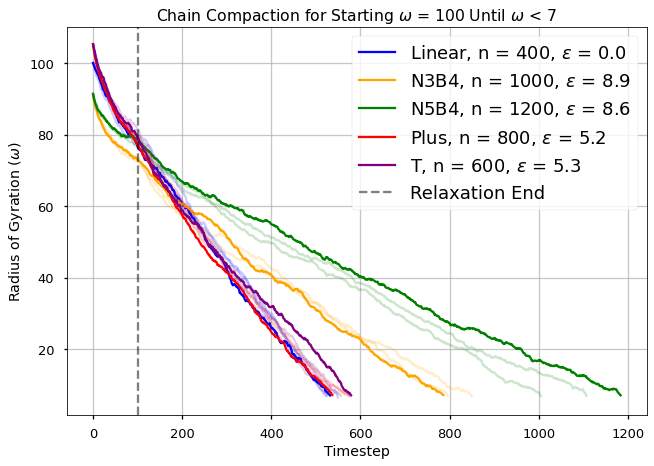

In [ ]:
rog_plot_one_startingrog(100)

##### newer

In [ ]:
def rog_get_slopes(rog):
    """
    Given an array of rogs <rog>, output slope based on post 100 timestep results.
    Post 100 because until 100 are equilibration timesteps.
    """
    rog_use = rog[rog > 7]
    slope = (rog_use[-1] - rog_use[100])/(len(rog_use)-100)
    return slope


In [ ]:
slopes_master = np.zeros((len(trials), len(runs), len(labels), 10))

for tn in range(len(trials)):
    for nn in range(len(runs)):
        for formn in range(len(labels)):
            # Skipping first two sizes due to being extremely short ([2:])
            slopes_master[tn][nn][formn] = [rog_get_slopes(rogi) for rogi in rog_master[tn][nn][formn][2:]]


In [ ]:
slopes_mean = np.mean(slopes_master, (0, 1))
slopes_SEM = np.std(slopes_master, (0, 1)) / np.sqrt(9)

<ipython-input-41-02db485e0428>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-talk')


Text(0.5, 0.01, 'Polymer Size')

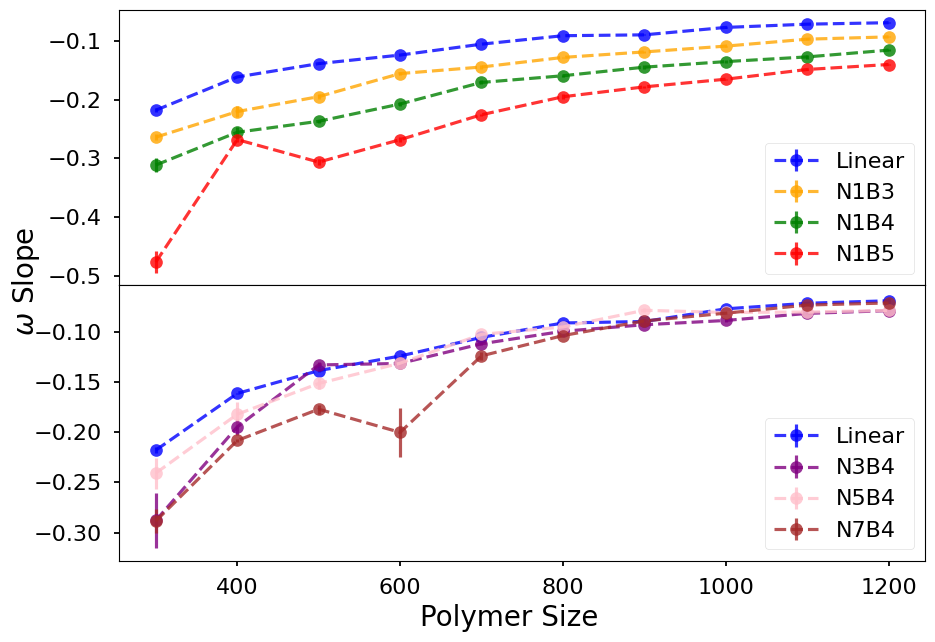

In [ ]:
# Plot average ROG slopes

fig, axs = plt.subplots(2, 1, sharex=True)
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)

mpl.style.use('seaborn-talk')

for i, o in enumerate(slopes_mean):
    if i in mononuc_i:
        axs[0].errorbar(np.linspace(300, 1200, 10), o,
                        yerr = slopes_SEM[i],
                        fmt = 'o--', label=labels[i],
                        color=colormap[i], alpha=.8)
    if i in multinuc_i:
        axs[1].errorbar(np.linspace(300, 1200, 10), o,
                        yerr = slopes_SEM[i],
                        fmt = 'o--', label=labels[i],
                        color=colormap[i], alpha=.8)

axs[0].tick_params(labelsize=tick_fsize)
axs[1].tick_params(labelsize=tick_fsize)
axs[0].legend(fontsize=tick_fsize)
axs[1].legend(fontsize=tick_fsize)
fig.supylabel(f"$\omega$ Slope", fontsize=axes_fsize)
fig.supxlabel("Polymer Size", fontsize=axes_fsize)
# plt.title(f"Various Chain Radius of Gyration ($\omega$) Compaction Slopes")




<ipython-input-42-fda04ad5c309>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-talk')


Text(0.5, 0.01, 'Polymer Size')

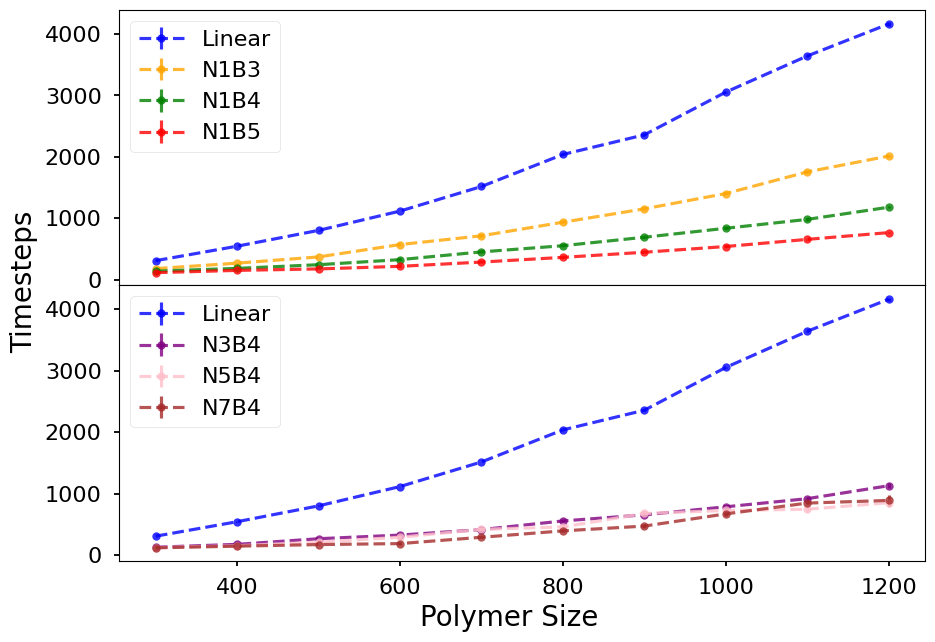

In [ ]:
# Plot overall timesteps required to achieve ROG cutoff

fig, axs = plt.subplots(2, 1, sharex=True)
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)

mpl.style.use('seaborn-talk')

for i, c in enumerate(cutoffmeans):
    if i in mononuc_i:
        axs[0].errorbar(np.linspace(300, 1200, 10), c[2:], yerr=cutoffstds[i][2:],
                 fmt='o--', markersize = 6, mec='black', label = labels[i],
                 color=colormap[i], alpha=.8)
    if i in multinuc_i:
        axs[1].errorbar(np.linspace(300, 1200, 10), c[2:], yerr=cutoffstds[i][2:],
                 fmt='o--', markersize = 6, mec='black', label = labels[i],
                 color=colormap[i], alpha=.8)

axs[0].tick_params(labelsize=tick_fsize)
axs[1].tick_params(labelsize=tick_fsize)
axs[0].legend(fontsize=tick_fsize)
axs[1].legend(fontsize=tick_fsize)
fig.supylabel("Timesteps", fontsize=axes_fsize)
fig.supxlabel("Polymer Size", fontsize=axes_fsize)
# plt.title("Timesteps to Achieve a $\omega$ < 7")



In [ ]:
# Gather initial ROG's for reference
# adapted for multiple trials
# Again using larger chains, excluding two smallest
initial_rogs = np.zeros((len(trials), len(runs), len(labels), 10))
initial_rogs_SEM = np.zeros((len(trials), len(runs), len(labels), 10))

for tn in range(len(trials)):
    for nn in range(len(runs)):
        for formn in range(len(labels)):
            # Skipping first two sizes due to being extremely short ([2:])
            initial_rogs[tn][nn][formn] = [rog[0] for rog in rog_master[tn][nn][formn][2:]]

initial_rogs_mean = np.mean(initial_rogs, (0, 1))
initial_rogs_SEM = np.std(initial_rogs, (0, 1)) / np.sqrt(9)

# Form ratios of timestep / inital ROG
ratio = cutoffmeans[:, 2:] / initial_rogs_mean

In [ ]:
# Error propoagation for the division of two averaged variables

# c = a/b * sqrt((a_err / a)**2 + (b_err / b)**2)

ratio_SEM = ratio * np.sqrt((cutoffstds[:, 2:]/cutoffmeans[:, 2:])**2 + (initial_rogs_SEM/initial_rogs_mean)**2)

<ipython-input-48-f2e64aac0ff1>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-talk')


Text(0.5, 0.01, 'Polymer Size')

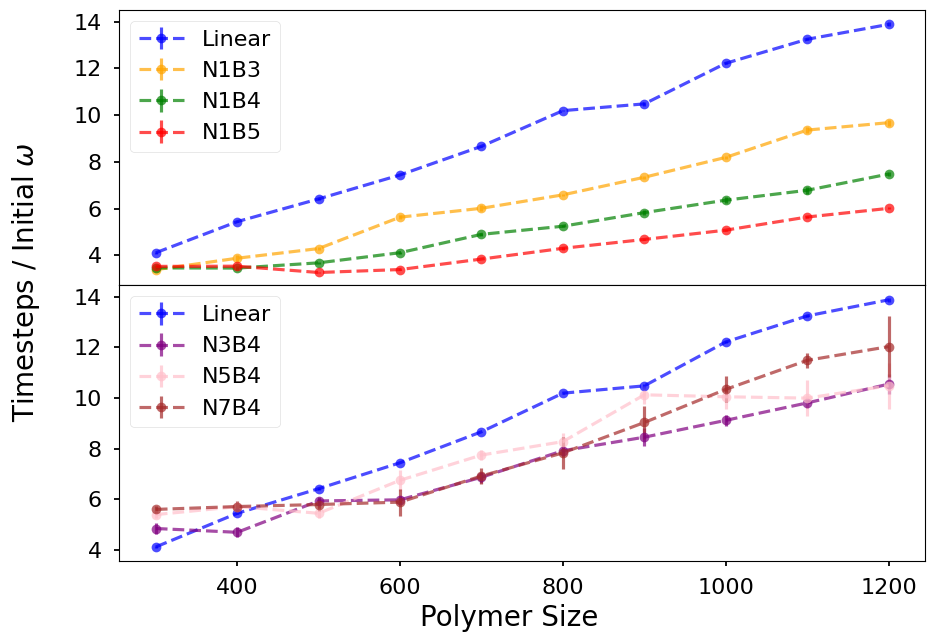

In [ ]:
# Plotting ratio of timestep / initial ROG over all shapes and sizes

fig, axs = plt.subplots(2, 1, sharex=True)
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)

mpl.style.use('seaborn-talk')

for i, c in enumerate(ratio):
    if i in mononuc_i:
        axs[0].errorbar(np.linspace(300, 1200, 10),
                 c, alpha = .7,
                 yerr = ratio_SEM[i],
                 markersize=7, color=colormap[i],
                 fmt = 'o--', label = labels[i])
    if i in multinuc_i:
        axs[1].errorbar(np.linspace(300, 1200, 10),
                 c, alpha = .7,
                 yerr = ratio_SEM[i],
                 markersize=7, color=colormap[i],
                 fmt = 'o--', label = labels[i])

axs[0].tick_params(labelsize=tick_fsize)
axs[1].tick_params(labelsize=tick_fsize)
axs[0].legend(fontsize=tick_fsize)
axs[1].legend(fontsize=tick_fsize)
fig.supylabel(f"Timesteps / Initial $\omega$", fontsize=axes_fsize)
fig.supxlabel("Polymer Size", fontsize=axes_fsize)
# plt.title("Ratio of Timesteps to Achieve $\omega$ < 7 to Initial $\omega$")

### RMSD

#### (RMSD) Extraction, Saving data to files

In [ ]:
# Run once to create RMSD data files

for tn, t in enumerate(trials):

    for nn, n in enumerate(runs):

        for formn, form in enumerate(labels):

             # List of trajectory filenames
            traj_filenames = get_file_list_V2(folderpath + form + "/" + t + 'trjs' + n)

            # Loop over each trajectory file
            for k, traj_filename in enumerate(traj_filenames):

                # Create a Universe object for the current trajectory
                curr_u = mda.Universe(get_file_list_V2(folderpath + form + "/" + t + 'dats' + runs[tn])[k],
                                      traj_filename,
                                      topology_format = "DATA",
                                      format = "LAMMPSDUMP")

                rmsdhere = mda.analysis.rms.RMSD(curr_u, curr_u, ref_frame=0).run()

                # Save the average trajectory to a file
                # traj{run}_{atomtotal}.txt
                np.savetxt(folderpath + form + "/" + t + "rmsds" + n + f"/traj{nn+1}_{(k+1)*100}.txt", rmsdhere.rmsd, delimiter='\t')




/usr/local/lib/python3.10/dist-packages/MDAnalysis/coordinates/LAMMPS.py:598: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data['time'] = step_num * ts.dt
/usr/local/lib/python3.10/dist-packages/MDAnalysis/analysis/rms.py:722: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


#### (RMSD) Visualization

In [ ]:
# Updated to accomodate multiple trials
# Gather RMSD compaction slope for all polymers
# Runtime ~2m

# Specific polymer sizes, because others are either too long or too short
x = np.linspace(600, 1000, 5)

rmsd_slopes = np.zeros((len(trials), len(runs), len(labels), len(x)))
rmsd_slopes_SEM = np.zeros((len(trials), len(runs), len(labels), len(x)))
rmsd_master = [[] for _ in range(len(labels))]

for tn, t in enumerate(trials):
    for nn, n in enumerate(runs):

        for formn, form in enumerate(labels):
            slopeline = []
            slopeerr = []

            # For particular polymer sizes
            for totn, tot in enumerate(x):
                slopes = []

                data = np.loadtxt(folderpath + form + "/" + t + "rmsds" + n + f"/traj{nn+1}_{int(tot)}.txt", delimiter="\t")[:,2]
                # rightlim = 0 + n/2
                # rightlim = int(rightlim)

                # Trim these shapes because simulations keep going with no change
                if tot == 1000 and form == "Linear" and tn == 0 and nn == 0:
                    data = data[:3000]
                if tot == 1000 and form == "N1B4" and tn == 0 and nn == 0:
                    data = data[:900]

                # rmsd_master format: ascending n, then ascending trial/run
                rmsd_master[formn].append(data)
                rmsd_slopes[tn][nn][formn][totn] = ((data[-1] - data[100]) / (len(data) - 100))


rmsd_slopes_mean = np.mean(rmsd_slopes, (0, 1))
rmsd_slopes_SEM = np.std(rmsd_slopes, (0, 1)) / np.sqrt(9)

In [ ]:
len(rmsd_master[0][11])

1521

In [ ]:
def rmsd_same_n(n):

    alphas = [.3, .3]

    for i, f in enumerate(folders):
        data = np.loadtxt(f + f"/rmsds/traj1_{n}.txt", delimiter="\t")[:,2]

        # Trim these shapes because simulations keep going with no change
        if n == 1000 and f == "linear":
            data = data[:3000]
        if n == 1000 and f == "plusshaped":
            data = data[:900]

        plt.plot(data,
                c = colormap[i],
                label = chain_labels[i])

        for k in range(2):
            plt.plot(np.loadtxt(f + f"/rmsds/traj{k+2}_{n}.txt", delimiter="\t")[:,2],
                     c = colormap[i],
                     alpha = alphas[k])

    plt.title(f"RMSD for Branched Polymers with Size n = {n}")
    plt.axvline(100, linestyle='dashed', c='black', label="Relaxation End", alpha = .5)
    plt.legend()
    plt.ylabel("RMSD")
    plt.xlabel("Timestep")





In [ ]:
def rmsd_same_n(n):
    """
    Given the total number of monomers (n) desired, plot the RMSD over time
    of each polymer that equals n.

    args
    ------
    n: total number of polymers <must be in range [600, 1000]>
    """

    # remember
    # Specific polymer sizes, because others are either too long or too short
    # x = np.linspace(600, 1000, 5)
    # so rmsd_master is shorter, (3 trials * 3 runs * 5 ns) * 7 forms


    fig, axs = plt.subplots(1, 1)

    mpl.style.use('seaborn-talk')

    for formn in range(len(labels)):
        for allrunn in range(len(trials)*len(runs)):
            rmsd_i = rmsd_master[formn][int(5*allrunn)]

            # highlight first run case
            if allrunn == 1:
                axs.plot(rmsd_i, c=colormap[formn], label=labels[formn])

            # other run cases are much more transparent
            else:
                axs.plot(rmsd_i, alpha=.2, c=colormap[formn])

    axs.axvline(100, linestyle='dashed', c='black', label="Relaxation End", alpha = .5)
    axs.tick_params(labelsize=tick_fsize)
    axs.legend(title=f"n = {n}", fontsize=tick_fsize, title_fontsize=axes_fsize)
    fig.supylabel("RMSD", fontsize=axes_fsize)
    fig.supxlabel("Timestep", fontsize=axes_fsize)

<ipython-input-70-ed7975471d4b>:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-talk')


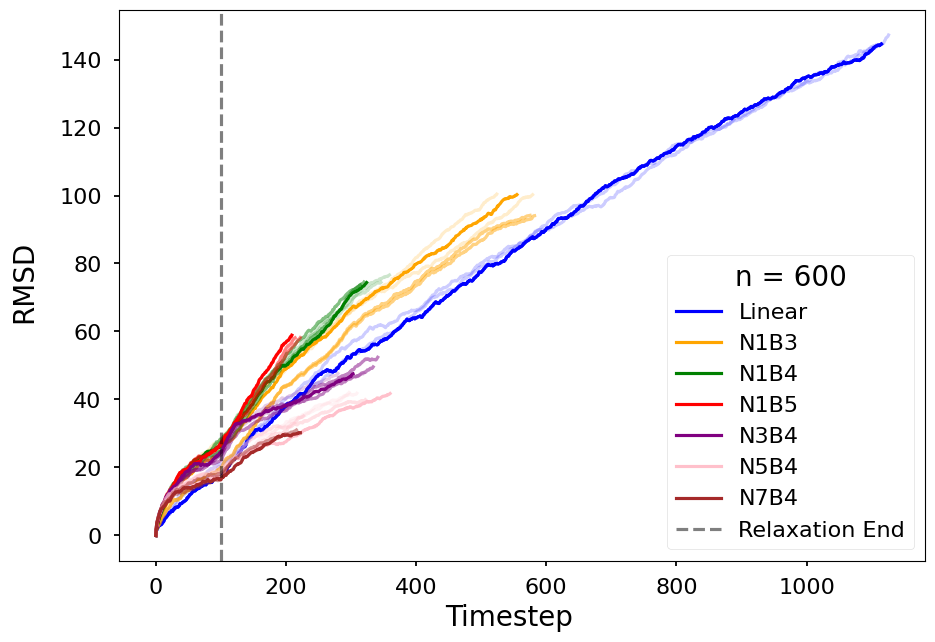

In [ ]:
rmsd_same_n(600)

<ipython-input-70-ed7975471d4b>:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-talk')


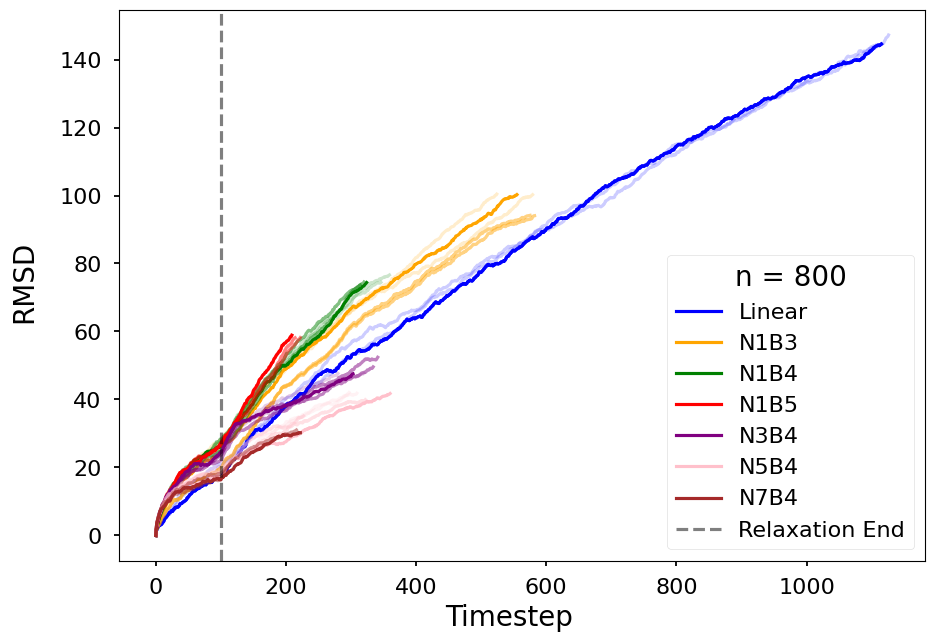

In [ ]:
rmsd_same_n(800)

<ipython-input-70-ed7975471d4b>:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-talk')


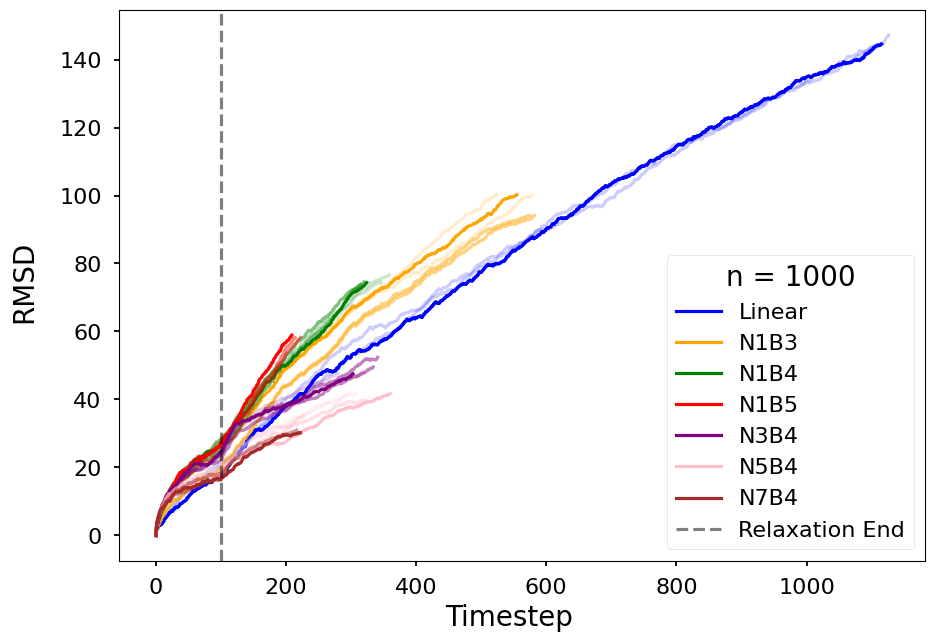

In [ ]:
rmsd_same_n(1000)

<ipython-input-69-a01650a94dec>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-talk')


Text(0.5, 0.01, 'Polymer Size')

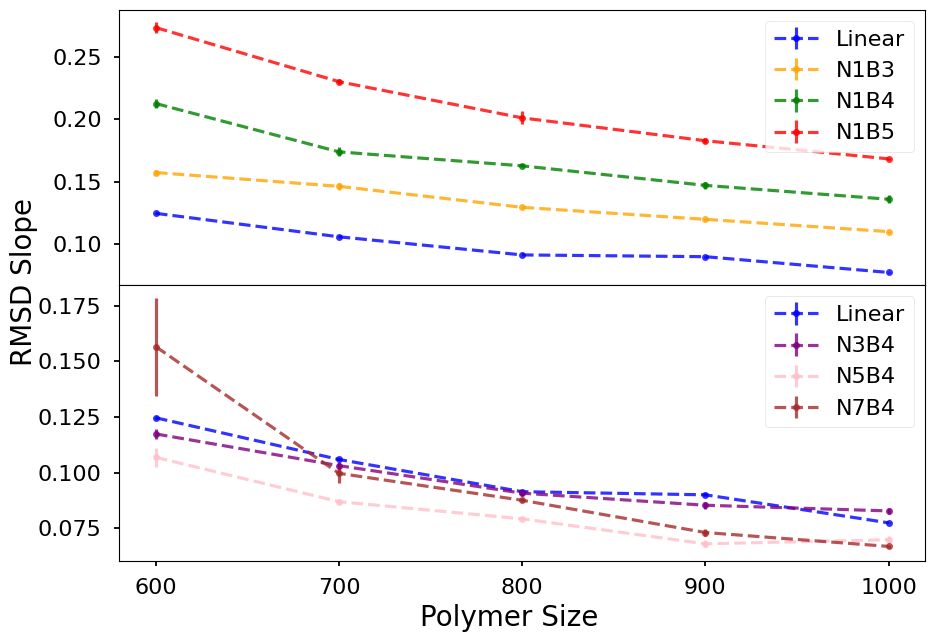

In [ ]:
# Updated to accomodate multiple trials
# Plot RMSD compaction slope for all polymers


# plt.xticks(x, [int(xs) for xs in x])

fig, axs = plt.subplots(2, 1, sharex=True)
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)

mpl.style.use('seaborn-talk')

for i, c in enumerate(rmsd_slopes_mean):
    if i in mononuc_i:
        axs[0].errorbar(x,
                c, alpha = .8,
                yerr = rmsd_slopes_SEM[i],
                markersize=5, color=colormap[i],
                fmt = 'o--', label = labels[i])
    if i in multinuc_i:
        axs[1].errorbar(x,
                c, alpha = .8,
                yerr = rmsd_slopes_SEM[i],
                markersize=5, color=colormap[i],
                fmt = 'o--', label = labels[i])

axs[1].set_xticks(x, [int(xs) for xs in x])
axs[0].tick_params(labelsize=tick_fsize)
axs[1].tick_params(labelsize=tick_fsize)
axs[0].legend(fontsize=tick_fsize)
axs[1].legend(fontsize=tick_fsize)
fig.supylabel("RMSD Slope", fontsize=axes_fsize)
fig.supxlabel("Polymer Size", fontsize=axes_fsize)
# plt.title(f"RMSD Compaction Slope for Polymers")